This was the first Kaggle competition I tried and was learning about Neural Networks at the time, so that was the solution I wanted to try. I wouldn't suggest this solution for a production environment as Boosted Trees, or even Random Forests seemed to outperform it in tests. It seems it's pretty hard to beat boosted trees for tabular data ML tasks. That's probably especially true for this one because of the severely imbalanced data set.

In [1]:
import os
import gc
import random
import pathlib
import multiprocessing
from pprint import pprint, pformat

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import fastai
from fastai import metrics
from fastai.tabular import FillMissing, Categorify, Normalize, DatasetType
from fastai.tabular import TabularDataBunch, tabular_learner, TabularList, load_learner
print(fastai.__version__)

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# DIRS
INPUT = pathlib.Path('/kaggle/input/')
MODELS = pathlib.Path('.')
NROWS = None

print("Input Files:")
for dirname, _, filenames in os.walk(INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))


1.0.57
Input Files:
/kaggle/input/ieee-reduce-mem/test.pkl
/kaggle/input/ieee-reduce-mem/train.pkl
/kaggle/input/ieee-reduce-mem/custom.css
/kaggle/input/ieee-reduce-mem/__notebook__.ipynb
/kaggle/input/ieee-reduce-mem/__results__.html
/kaggle/input/ieee-reduce-mem/__output__.json
/kaggle/input/ieee-reduce-mem/__results___files/__results___28_2.png
/kaggle/input/ieee-fastai-data/valid_idx.csv
/kaggle/input/ieee-fastai-data/custom.css
/kaggle/input/ieee-fastai-data/__notebook__.ipynb
/kaggle/input/ieee-fastai-data/__results__.html
/kaggle/input/ieee-fastai-data/__output__.json
/kaggle/input/ieee-fastai-data/train_df.pkl
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


I wasnt sure about excluding the 'TransactionDT' column here but some other kagglers seemed to think that it was unevenly distributed and causing models to overfit. Once we have a pipeline maybe we can try adding it back in an see if it improves anything.

In [2]:
def get_cat_names(df):
    """Get a list of all category column names"""
    print(f"\n==get_cat_names==")
    cards = [f"card{i}" for i in range(1, 7)]
    matches = [f"M{i}" for i in range(1, 10)]
    trx_cats = ["ProductCD", "addr1", "addr2", "P_emaildomain", "R_emaildomain", *cards, *matches]
    ids = [f"id_{i}" for i in range(12, 39)]
    id_cats = ["DeviceType", "DeviceInfo", *ids]
    cat_names = trx_cats + id_cats
    cat_names = [x for x in cat_names if x in df.columns]
    cont_names = [x for x in df.columns if x not in cat_names]

    excluded_columns = ['TransactionID', 'TransactionDT', 'isFraud']
    for col in excluded_columns:
        for col_list in [cat_names, cont_names]:
            if col in col_list:
                col_list.remove(col)
    print(f"cat_names: {len(cat_names)} {cat_names[:10]}...")
    print(f"cont_names: {len(cont_names)} {cont_names[:10]}...")
    return cat_names, cont_names

dup_idx_start = 4000000

def oversample(df, num=4):
    print(f"\n==oversample==")
    fraud_trx = df.loc[df['isFraud'] == 1]
    print(f"Original isFraud Count {len(fraud_trx)} rows")
    print(f"Original Rows Count {len(df)} rows")
    print(f"Original pct: {int(len(fraud_trx) / len(df) * 100)}%")

    fraud_trx = pd.concat([fraud_trx] * num, axis=0)
    # We're giving them all IDs starting at 4, so they will be easy to ID later,
    # Just make sure the model doesnt see that or it will totally overfit to that
    new_idx = list(range(dup_idx_start, dup_idx_start + len(fraud_trx)))
    fraud_trx['TransactionID'] = new_idx
    print(f"Adding New Rows: {len(fraud_trx)} rows")

    new_df = pd.concat([df, fraud_trx], axis=0, sort=False)
    new_fraud = new_df.loc[new_df['isFraud'] == 1]
    print(f"New isFraud Count {len(new_fraud)} rows")
    print(f"New Rows Count {len(new_df)} rows")
    print(f"New pct: {int(len(new_fraud) / len(new_df) * 100)}%")
    return new_df

def add_null_values(df):
    """
    C_ columns have NaN values in the test set but not in the train set.
    Fastai will not play nicely unless there are equivalent NaN values in the train set, and they
    must be in the training portion, not the validation portion.
    """
    print(f"\n==add_null_values==")    
    if NROWS:
        for col in df.columns:
            try:
                df.at[0, col] = np.nan
            except Exception:
                pass
        return df
    null_columns = [col for col in df.columns if col.startswith('C')]
    for col in null_columns:
        df[col] = df[col].astype('float')
        df.at[0, col] = np.nan
        df[col] = pd.to_numeric(df[col], downcast='float')
    print(df[null_columns].head())
    return df


Fastai could do a random split for us but it messes up with the NaN values sometimes so to make sure it works we give it our own valid_idx and make sure the 0th index isnt in it. (0th index because that's the row add_null_values() will use)

Note:
I had to be careful selecting a validation set that has enough isFraud trx in it. I undersampled in an earlier test and got 100% validation cause everything was non-fraudulent.

In [3]:
def get_valid_idx(train, pct=0.2):
    print(f"\n==get_valid_idx==")
    isFraud = train[train['isFraud'] == 1]
    noFraud = train[train['isFraud'] == 0]
    print(f"IsFraud: {len(isFraud)}\tNoFraud: {len(noFraud)}")
    _, isFraud_idx = train_test_split(list(isFraud.index), test_size=pct)
    _, noFraud_idx = train_test_split(list(noFraud.index), test_size=pct)
    valid_idx = sorted(isFraud_idx + noFraud_idx)[1:]
    print(f"Getting {pct*100}% of indexes: {len(valid_idx)}/{len(train.index)}")
    print(f"Valid Indexes: {valid_idx[:10]}")
    return valid_idx

dep_var = 'isFraud'

def train_pipeline(train):
    print(f"==train_pipeline==")   
    procs = [FillMissing, Categorify, Normalize]
    cat_names, cont_names = get_cat_names(train)
        
    train = oversample(train, 4)
    train = add_null_values(train)
    valid_idx = get_valid_idx(train)

    print(f"\n==making TabularList==")
    data = TabularList.from_df(train, cat_names=cat_names, cont_names=cont_names, procs=procs)\
        .split_by_idx(valid_idx)\
        .label_from_df(cols=dep_var)\
        .databunch()
    return data

In [4]:
def get_train_datablock():
    print(f"==train_pipeline==")   
    train = pd.read_pickle(INPUT / 'ieee-fastai-data' / 'train_df.pkl')
    train = train.reset_index(drop=True)
    valid_idx = list(pd.read_csv(INPUT / 'ieee-fastai-data' / 'valid_idx.csv')['index'])
    display(train.head())
    print(f"valid_idx: {len(valid_idx)}, {valid_idx[:10]}...")
    print(f"train.columns: {len(train.columns)}, {train.columns}...")
    procs = [FillMissing, Categorify, Normalize]
    cat_names, cont_names = get_cat_names(train)
    print(f"\n==making TabularList==")
    data = TabularList.from_df(train, cat_names=cat_names, cont_names=cont_names, procs=procs)\
        .split_by_idx(valid_idx)\
        .label_from_df(cols=dep_var)\
        .databunch()
    return data

In [5]:
train = get_train_datablock()

==train_pipeline==


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


valid_idx: 88581, [2, 6, 7, 24, 31, 36, 39, 43, 52, 53]...
train.columns: 434, Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)...

==get_cat_names==
cat_names: 49 ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card4', 'card5']...
cont_names: 382 ['TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']...

==making TabularList==


In [6]:
learn = tabular_learner(train, layers=[400, 100], emb_drop=0.3, ps=[0.3, 0.3], metrics=[metrics.AUROC()])

In [7]:
gc.collect()

22

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


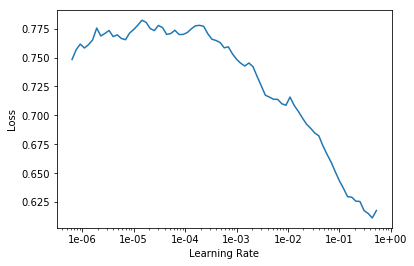

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
i = 1
learn.fit_one_cycle(3, 1e-3)
model_name = f"400-100-model_{i}"
learn.export(model_name + '.pkl')

epoch,train_loss,valid_loss,auroc,time
0,0.218241,0.178480,0.917751,14:48
1,0.179146,0.764045,0.936935,14:53


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


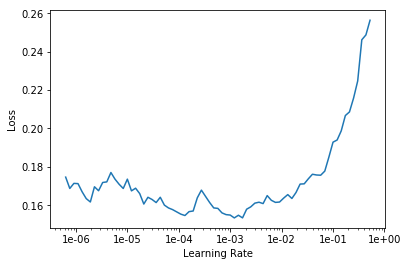

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
gc.collect()

7597

In [12]:
learn.validate()

[8.900774, tensor(0.9372)]

The model is trained and in the next kernel we test it and open it up a bit.